<a href="https://colab.research.google.com/github/AngXiao01/shared/blob/main/OR_VRP_Heuristic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the dataset

In [46]:
import random

# Define problem size
num_customers = 20
num_vehicles = 8

# Define customer information
customers = []
for i in range(num_customers):
    x = round(random.uniform(-100, 100))  # x-coordinate
    y = round(random.uniform(-100, 100))  # y-coordinate
    demand = random.randint(1, 10)  # demand
    customers.append((x, y, demand))

# Define vehicle information
vehicles = []
for i in range(num_vehicles):
    capacity = random.randint(10, 20)  # capacity
    speed = round(random.uniform(10, 20))  # speed
    vehicles.append((capacity, speed))

# Define constraints
vehicle_capacity = [v[0] for v in vehicles]  # vehicle capacity constraints

# Define solution format
routes = [[] for i in range(num_vehicles)]  # list of routes for each vehicle

print("customers' (location x, location y, demand) = {}".format(customers))
print("vehicles' (capacity, speed) = {}".format(vehicles))

customers' (location x, location y, demand) = [(29, 37, 1), (10, -17, 4), (93, 11, 4), (88, 72, 3), (-40, -70, 1), (75, 49, 4), (46, 35, 6), (-16, -62, 6), (25, 80, 8), (24, 57, 2), (77, 82, 4), (-49, 44, 5), (-23, 95, 3), (37, 24, 1), (8, -23, 8), (-73, -60, 3), (87, -88, 1), (-39, -53, 1), (-38, -60, 6), (-51, -74, 6)]
vehicles' (capacity, speed) = [(17, 12), (19, 16), (19, 20), (11, 19), (11, 19), (19, 15), (14, 15), (12, 11)]


In [47]:
routes

[[], [], [], [], [], [], [], []]

# Heuristic Algorithm

In [48]:
import numpy as np

# Calculate the distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Find the nearest customer to a given location
def nearest_neighbor(loc, unvisited_customers):
    nn = unvisited_customers[0]
    min_dist = distance(loc, nn[:2])
    for c in unvisited_customers:
        dist = distance(loc, c[:2])
        if dist < min_dist:
            nn = c
            min_dist = dist
    return nn

# Initialize the algorithm
solution_found = False
total_distance = 0
while not solution_found:
    unvisited_customers = customers.copy()
    for i, v in enumerate(vehicles):
        current_location = (0, 0)  # start at the depot
        route = [current_location]
        capacity = v[0]
        while len(unvisited_customers) > 0:
            nearest = nearest_neighbor(current_location, unvisited_customers)
            if nearest[2] <= capacity:
                route.append(nearest[:2])
                current_location = nearest[:2]
                capacity -= nearest[2]
                unvisited_customers.remove(nearest)
            else:
                break
        route.append((0, 0))  # return to the depot
        routes[i] = route
    # Check if all customers have been visited
    if len(unvisited_customers) == 0:
        solution_found = True
    else:
        total_distance += 100000  # assign a large penalty to infeasible solutions

# Print the solution
print("Total distance travelled: %.2f" % total_distance)
for i, r in enumerate(routes):
    print("Vehicle %d route: %s" % (i+1, r))


Total distance travelled: 0.00
Vehicle 1 route: [(0, 0), (10, -17), (8, -23), (0, 0)]
Vehicle 2 route: [(0, 0), (37, 24), (46, 35), (29, 37), (24, 57), (25, 80), (0, 0)]
Vehicle 3 route: [(0, 0), (-16, -62), (-38, -60), (-39, -53), (-40, -70), (0, 0)]
Vehicle 4 route: [(0, 0), (-49, 44), (-23, 95), (0, 0)]
Vehicle 5 route: [(0, 0), (75, 49), (88, 72), (77, 82), (0, 0)]
Vehicle 6 route: [(0, 0), (-51, -74), (-73, -60), (87, -88), (93, 11), (0, 0)]
Vehicle 7 route: [(0, 0), (0, 0)]
Vehicle 8 route: [(0, 0), (0, 0)]


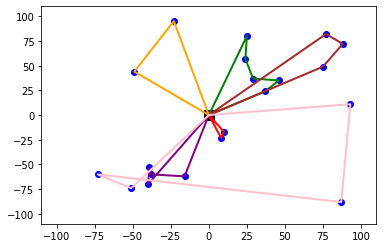

In [49]:
import matplotlib.pyplot as plt

# Plot the customers
x = [c[0] for c in customers]
y = [c[1] for c in customers]
plt.scatter(x, y, c='blue')

# Plot the routes
colors = ['red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']
for i, r in enumerate(routes):
    xs = [p[0] for p in r]
    ys = [p[1] for p in r]
    plt.plot(xs, ys, color=colors[i], linewidth=2)

# Plot the depot
plt.scatter(0, 0, c='black', marker='s', s=100)

# Set the axis limits
plt.xlim(-110, 110)
plt.ylim(-110, 110)

# Show the plot
plt.show()


# Branch and Bound

In [17]:
import numpy as np

def tsp_dist(points):
    """Calculate pairwise distances between points."""
    n = len(points)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(points[i] - points[j])
            dist[i,j] = dist[j,i] = d
    return dist

def branch_and_bound_vrp(points, capacity, depot=0):
    """
    Solves the Vehicle Routing Problem (VRP) using the branch-and-bound algorithm.

    Parameters:
        points (np.ndarray): Array of shape (n, 2) representing the (x,y) coordinates of n points.
        capacity (float): Maximum capacity of each vehicle.
        depot (int): Index of the depot node. Defaults to 0.

    Returns:
        (float, list): A tuple consisting of the optimal distance and the optimal route.
    """
    n = len(points)
    dist = tsp_dist(points)

    # Set up initial variables
    best_dist = np.inf
    best_route = None
    q = [(0, [], np.ones(n, dtype=bool))]  # (cost, route, unvisited)
    while q:
        cost, route, unvisited = q.pop(0)

        # Check if we've visited all nodes
        if np.sum(unvisited) == 0:
            # Add return to depot
            route += [depot]
            cost += dist[route[-2], depot]
            if cost < best_dist:
                best_dist = cost
                best_route = route
            continue

        # Check if cost is worse than best route
        if cost > best_dist:
            continue

        # Find the next unvisited node
        for i in range(n):
            if not unvisited[i]:
                continue
            new_cost = cost + dist[route[-1], i]
            if new_cost > capacity:
                continue
            new_route = route + [i]
            new_unvisited = unvisited.copy()
            new_unvisited[i] = False
            q.append((new_cost, new_route, new_unvisited))

        # Sort the queue by cost
        q.sort()

    return best_dist, best_route

In [18]:
branch_and_bound_vrp(customers, capacity, depot=0)

TypeError: ignored

# Another Try

In [20]:
pip install pyomo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.9 MB/s eta 0:00:00


In [21]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import networkx as nx
import matplotlib.pyplot as plt

# Define the dataset
num_vehicles = 2
num_customers = 10
vehicle_capacity = 50
customer_demands = [10, 20, 5, 15, 30, 25, 10, 15, 5, 20]
customer_locations = [(35, 65), (15, 45), (40, 40), (20, 35), (10, 30), (30, 30), (5, 15), (20, 20), (30, 10), (45, 5)]

# Create the model
model = ConcreteModel()

# Define the sets
model.V = RangeSet(0, num_vehicles) # set of vehicles
model.C = RangeSet(1, num_customers) # set of customers

# Define the parameters
model.q = Param(model.C, initialize=lambda model, i: customer_demands[i-1])
model.d = Param(model.C, initialize=lambda model, i: customer_locations[i-1])
model.c = Param(model.C, model.C, initialize=lambda model, i, j: ((model.d[i][0]-model.d[j][0])**2+(model.d[i][1]-model.d[j][1])**2)**0.5)

# Define the variables
model.x = Var(model.C, model.C, model.V, within=Binary)
model.u = Var(model.C, within=NonNegativeReals)

# Define the objective function
def obj_rule(model):
    return sum(model.c[i, j] * model.x[i, j, k] for i in model.C for j in model.C for k in model.V)

model.obj = Objective(rule=obj_rule, sense=minimize)

# Define the constraints
def supply_rule(model, k):
    return sum(model.q[i] * model.x[i, j, k] for i in model.C for j in model.C) <= vehicle_capacity

model.supply = Constraint(model.V, rule=supply_rule)

def demand_rule(model, i):
    return sum(model.x[i, j, k] for j in model.C for k in model.V) == 1

model.demand = Constraint(model.C, rule=demand_rule)

def subtour_elimination_rule(model, i, j, k):
    if i != j:
        return model.u[i] - model.u[j] + num_customers * model.x[i, j, k] <= num_customers - 1
    else:
        return Constraint.Skip

model.subtour_elimination = Constraint(model.C, model.C, model.V, rule=subtour_elimination_rule)

# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(model)

# Print the solution
print("Status: ", results.solver.termination_condition)
print("Objective value: ", model.obj())

# Create a network graph of the solution
G = nx.DiGraph()
for k in model.V:
    for i in model.C:
        for j in model.C:
            if model.x[i, j, k]() > 0.5:
                G.add_edge(i, j, weight=model.c[i, j])

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=model.C, node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='b', arrows=True)
nx.draw_networkx_labels(G, pos, labels={i: f'{i}' for i in model.C})
plt.axis('off')
plt.show()


default domain for Param objects is 'Any'.  However, we will be
changing that default to 'Reals' in the future.  If you really intend
the domain of this Paramto be 'Any', you can suppress this warning by
explicitly specifying 'within=Any' to the Param constructor.
(deprecated in 5.6.9, will be removed in (or after) 6.0)
(called from /usr/local/lib/python3.8/dist-packages/pyomo/core/base/indexed_component.py:720)


ApplicationError: ignored